In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import time
from sklearn import preprocessing
from sys import path
path.append(r'E:\data_mining\project\IJCAI-17-口碑\koubei')
import base
import predict

import matplotlib
myfont = matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/msyh.ttf')
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#读取user_pay_count
user_pay_counts = base.ReadUserPayCountCSV();
#读取开店时间数据
shop_open_dates = base.ReadShopOpenDateCSV();
###读取商家信息
shop_infos = base.ReadShopInfoCSV();
##读取城市名称对照表
city_names = base.ReadCityNameCSV();
#读取休假表
calenders = base.ReadCalendarCSV();

In [27]:
train_data = pd.read_csv('../data/predict/fill_predict_data.txt', sep='\t', index_col=0, encoding='UTF-8')
train_data.columns = np.array(range(21))

In [28]:
mean_3_3_3_prediction = pd.read_csv('../data/predict/mean/3_3_3_prediction.txt', sep='\t', index_col=0, encoding='UTF-8')

In [29]:
arima_prediction = pd.read_csv('../data/predict/arima/arima_prediction.txt', sep='\t', index_col=0, encoding='UTF-8')
arima_prediction = predict.FixFinalPredict(arima_prediction)

In [30]:
blend_prediction = (mean_3_3_3_prediction + arima_prediction) / 2

In [31]:
blend_prediction.to_csv("../data/predict/classify_3/blend_prediction.txt", sep='\t', index=True, encoding='UTF-8')

In [32]:
#diff A-B
def judgePredIntersectType(s):
    #不相交
    if (len(s[s >= 0]) == 14 or len(s[s <= 0]) == 14):
        return 1
    else:
        return 0

In [33]:
train_df = pd.DataFrame()

In [34]:
intersects = mean_3_3_3_prediction - arima_prediction
intersects = intersects.apply(judgePredIntersectType, axis=1)
train_df['mean_arima_intersect'] = intersects

In [35]:
prev_week_data = train_data[np.array(range(14, 21))];

In [36]:
train_df['pre_week_mean'] = prev_week_data.mean(axis=1).astype(np.int)

In [37]:
#diff A-B 
def judgeMeanIntersectType(s):
    #不相交
    if (len(s[s >= 0]) == 14 or len(s[s <= 0]) == 14):
        return 1
    else:
        return 0

In [38]:
intersects = arima_prediction.sub(train_df['pre_week_mean'].squeeze(), axis=0)
train_df['arima_week_distance'] = np.abs(intersects.mean(axis=1))
intersects = intersects.apply(judgeMeanIntersectType, axis=1)
train_df['arima_week_intersect'] = intersects

In [39]:
intersects = mean_3_3_3_prediction.sub(train_df['pre_week_mean'].squeeze(), axis=0)
train_df['mean_week_distance'] = np.abs(intersects.mean(axis=1))
intersects = intersects.apply(judgeMeanIntersectType, axis=1)
train_df['mean_week_intersect'] = intersects

In [40]:
intersects = blend_prediction.sub(train_df['pre_week_mean'].squeeze(), axis=0)
train_df['blend_week_distance'] = np.abs(intersects.mean(axis=1))
intersects = intersects.apply(judgeMeanIntersectType, axis=1)
train_df['blend_week_intersect'] = intersects

In [41]:
X_train_data = train_data[np.array(range(21))]

In [42]:
def appendExtrelist(l, count):
    if len(l) == 0:
        l.append(count)
    elif l[len(l) - 1] != count:
        l.append(count)

def rebuildMaxlist(maxes):
    if len(maxes) < 2:
        return maxes
    
    threshold = 0.6
    remove_indexes = []
    for i in range(1, len(maxes) - 1):
        if (maxes[i] < maxes[i - 1] * threshold) and (maxes[i] < maxes[i + 1] * threshold):
            remove_indexes.append(i)
    
    rebuild_maxes = []
    for i in range(len(maxes)):
        if i not in remove_indexes:
            rebuild_maxes.append(maxes[i])
    
    return rebuild_maxes

def rebuildMinlist(mines):
    if len(mines) < 2:
        return mines
    
    threshold = 1.6
    remove_indexes = []
    for i in range(1, len(mines) - 1):
        if (mines[i] > mines[i - 1] * threshold) and (mines[i] > mines[i + 1] * threshold):
            remove_indexes.append(i)
    
    rebuild_mins = []
    for i in range(len(mines)):
        if i not in remove_indexes:
            rebuild_mins.append(mines[i])
            
    return rebuild_mins

#前14天趋势
#def 0 持平 1 上升 2 下降
def getPeriodTrend(id, start_index, end_index, threshold, user_pay_counts, shop_open_dates, calenders):

    df = X_train_data.loc[id][np.array(range(start_index, end_index))]
    print(df)
    maxes = []
    mins = []
    current_trend = 0
    prev_trend = 0;
    for i in df.index:
        if i == start_index:
            continue
        
        if df[i] > df[i - 1]:
            current_trend = 1
        elif df[i] < df[i - 1]:
            current_trend = 2
        else:
            current_trend = 0
                
        if i == start_index + 1:
            if current_trend == 1:
                appendExtrelist(mins, df[i - 1])
            elif current_trend == 2:
                appendExtrelist(maxes, df[i - 1])
        elif i == end_index - 1:
            if current_trend != prev_trend:
                if prev_trend == 0:
                    if current_trend == 1:
                        appendExtrelist(mins, df[i - 1])
                    else:
                        appendExtrelist(maxes, df[i - 1])
                elif prev_trend == 1:
                    appendExtrelist(maxes, df[i - 1])
                else:
                    appendExtrelist(mins, df[i - 1])
                
            if current_trend == 1:
                appendExtrelist(maxes, df[i])
            elif current_trend == 2:
                appendExtrelist(mins, df[i])
            else:
                appendExtrelist(maxes, df[i])
                appendExtrelist(mins, df[i])
        elif current_trend != prev_trend:
            if prev_trend == 0:
                if current_trend == 1:
                    appendExtrelist(mins, df[i - 1])
                else:
                    appendExtrelist(maxes, df[i - 1])
            elif prev_trend == 1:
                appendExtrelist(maxes, df[i - 1])
            else:
                appendExtrelist(mins, df[i - 1])
        
        prev_trend = current_trend
    
    print(maxes)
    print(mins)
    maxes = rebuildMaxlist(maxes)
    mins = rebuildMinlist(mins)
    max_trend = 0
    min_trend = 0
    if len(maxes) == 1:
        maxes = maxes + maxes
    elif len(maxes) == 0:
        maxes = [0, 0] + maxes
    
    print(maxes)
    print(mins)
    if len(mins) == 1:
        mins = mins + mins
    elif len(mins) == 0:
        mins = [0, 0] + mins
    
    max_mean = np.mean(maxes)
    min_mean = np.mean(mins)
    if np.mean(np.diff(maxes)) <= -max_mean * threshold:
        max_trend = 2
    elif np.mean(np.diff(maxes)) >= max_mean * threshold:
        max_trend = 1
    else:
        max_trend = 0
        
    if np.mean(np.diff(mins)) <= -min_mean * threshold:
        min_trend = 2
    elif np.mean(np.diff(mins)) >= min_mean * threshold:
        min_trend = 1
    else:
        min_trend = 0
        
    if max_trend == 0:
        return min_trend
    elif max_trend == 1:
        if min_trend == 2:
            return 0
        else:
            return 1
    elif max_trend == 2:
        if min_trend == 1:
            return 0
        else:
            return 2

In [65]:
prev_trends = []
threshold = 0.4
for id in range(1, 2001):
    print(id)
    prev_trends.append(getPeriodTrend(id, 7, 21, threshold, user_pay_counts, shop_open_dates, calenders))
    #print(getPeriodTrend(id, 7, 21, threshold, user_pay_counts, shop_open_dates, calenders))

1
7     244
8     177
9     207
10    230
11    202
12    243
13    216
14    255
15    172
16    226
17    257
18    251
19    281
20    180
Name: 1, dtype: int64
[244, 230, 243, 255, 257, 281]
[177, 202, 216, 172, 251, 180]
[244, 230, 243, 255, 257, 281]
[177, 202, 216, 172, 251, 180]
2
7      34
8      34
9      34
10     61
11    155
12    143
13     78
14     82
15     97
16     83
17     96
18     96
19    115
20     80
Name: 2, dtype: int64
[155, 97, 96, 115]
[34, 78, 83, 96, 80]
[155, 97, 96, 115]
[34, 78, 83, 96, 80]
3
7      59
8      71
9      88
10    103
11    127
12    125
13     47
14     80
15     61
16     68
17    103
18    102
19    104
20     67
Name: 3, dtype: int64
[127, 80, 103, 104]
[59, 47, 61, 102, 67]
[127, 80, 103, 104]
[59, 47, 61, 102, 67]
4
7      90
8     112
9      59
10     80
11    211
12    221
13     81
14     90
15    104
16     55
17    110
18    215
19    196
20    115
Name: 4, dtype: int64
[112, 221, 104, 215]
[90, 59, 81, 55, 115]
[112, 221, 21

In [66]:
train_df['prev_trend'] = prev_trends

In [43]:
train_df['mean_mean'] = mean_3_3_3_prediction.mean(axis=1)
train_df['arima_mean'] = arima_prediction.mean(axis=1)
train_df['blend_mean'] = blend_prediction.mean(axis=1)

In [44]:
periiodicity_df = pd.read_csv("../data/predict/common/periodicity_v2.txt", sep="\t", encoding='UTF-8', index_col=0)

In [45]:
rule_predictions = []
a = 0
for id in range(1, 2001):
    if ((periiodicity_df.loc[id]['mean_deviate'] > 0.50) and (periiodicity_df.loc[id]['mean_gap'] < 0.57)):
        #rule_predictions.append(train_df['blend'][id])
        a = a + 1
    #else:
        #rule_predictions.append(train_df['mean'][id])
#np.mean(rule_predictions)

In [70]:
intersect_df = train_df[(train_df['mean_arima_intersect'] == 0) & (train_df['mean_week_intersect'] == 0) & (train_df['arima_week_intersect'] == 0)]

In [71]:
intersect_df.count()

mean_arima_intersect    1009
pre_week_mean           1009
arima_week_distance     1009
arima_week_intersect    1009
mean_week_distance      1009
mean_week_intersect     1009
blend_week_distance     1009
blend_week_intersect    1009
prev_trend              1009
mean_mean               1009
arima_mean              1009
blend_mean              1009
dtype: int64

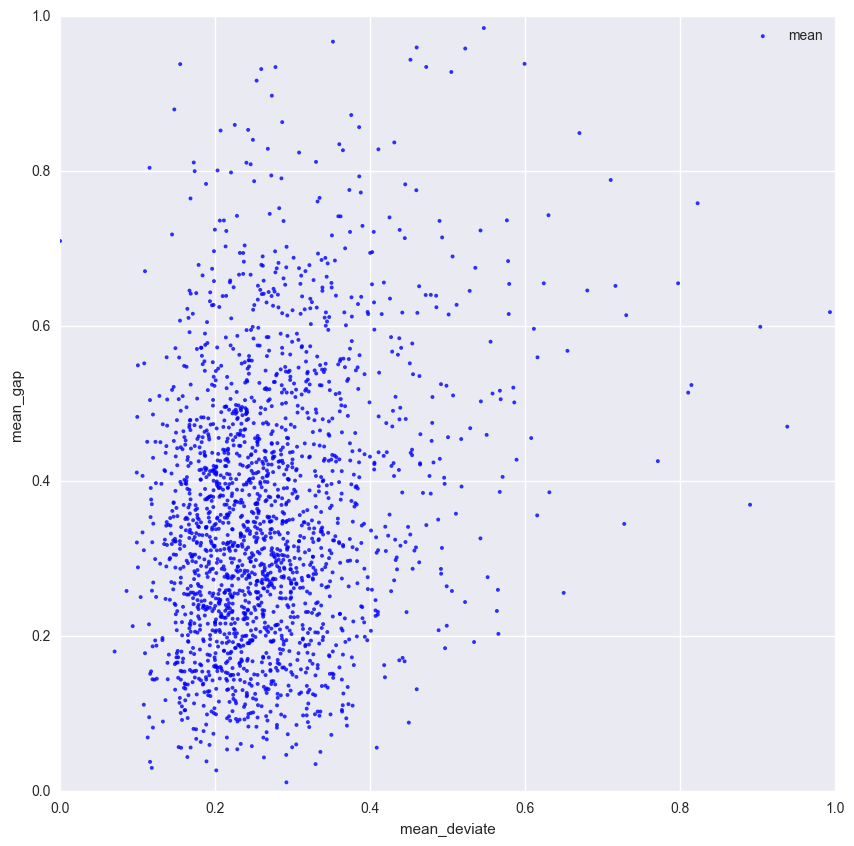

In [29]:
f, (ax) = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(periiodicity_df['mean_deviate'], periiodicity_df['mean_gap'] ,color='blue',s=8,edgecolor='none', alpha = 0.8, label='mean')
plt.xlim(0, 1)
plt.ylim(0,1)
ax.set_xlabel('mean_deviate')
ax.set_ylabel('mean_gap')
plt.legend()
plt.show()

In [46]:
X_train_df = pd.DataFrame()
# X_train_df['max'] = X_train_data.max(axis=1)
# X_train_df['min'] = X_train_data.min(axis=1)
# X_train_df['std'] = X_train_data.std(axis=1)
# X_train_df['var'] = X_train_data.var(axis=1)
# X_train_df['mean'] = X_train_data.mean(axis=1)
# X_train_df['median'] = X_train_data.median(axis=1)

In [47]:
# X_train_df['mean_max'] = mean_3_3_3_prediction.max(axis=1)
# X_train_df['mean_min'] = mean_3_3_3_prediction.min(axis=1)
#X_train_df['mean_std'] = mean_3_3_3_prediction.std(axis=1)
# X_train_df['mean_var'] = mean_3_3_3_prediction.var(axis=1)
X_train_df['mean_mean'] = mean_3_3_3_prediction.mean(axis=1)
# X_train_df['mean_median'] = mean_3_3_3_prediction.median(axis=1)
# X_train_df['arima_max'] = arima_prediction.max(axis=1)
# X_train_df['arima_min'] = arima_prediction.min(axis=1)
#X_train_df['arima_std'] = arima_prediction.std(axis=1)
# X_train_df['arima_var'] = arima_prediction.var(axis=1)
X_train_df['arima_mean'] = arima_prediction.mean(axis=1)
# X_train_df['arima_median'] = arima_prediction.median(axis=1)

X_train_df['blend_mean'] = blend_prediction.mean(axis=1)

X_train_df['prev_week_mean'] = train_df['pre_week_mean']

train_df['mean_mean_arima'] = train_df['mean_mean'] - train_df['arima_mean']

In [48]:
X_train_df['daytype_mean_std'] = periiodicity_df['mean_std']
X_train_df['daytype_std_1'] = periiodicity_df['std_1']
X_train_df['daytype_std_2'] = periiodicity_df['std_2']
X_train_df['daytype_std_3'] = periiodicity_df['std_3']
X_train_df['daytype_std_5'] = periiodicity_df['std_5']

X_train_df['std_mean'] = periiodicity_df['std_mean']
X_train_df['deviate_1'] = periiodicity_df['deviate_1']
X_train_df['deviate_2'] = periiodicity_df['deviate_2']
X_train_df['deviate_3'] = periiodicity_df['deviate_3']
X_train_df['deviate_5'] = periiodicity_df['deviate_5']

X_train_df['trend_0'] = periiodicity_df['trend_0']
X_train_df['trend_1'] = periiodicity_df['trend_1']
X_train_df['trend_2'] = periiodicity_df['trend_2']
X_train_df['trend_3'] = periiodicity_df['trend_3']
X_train_df['trend_4'] = periiodicity_df['trend_4']
X_train_df['trend_5'] = periiodicity_df['trend_5']
X_train_df['trend_6'] = periiodicity_df['trend_6']

X_train_df['mean_deviate'] = periiodicity_df['mean_deviate']
X_train_df['mean_gap'] = periiodicity_df['mean_gap']

In [49]:
X_train_df['diff_arima_max'] = arima_prediction.max(axis=1) - prev_week_data.max(axis=1)
X_train_df['diff_arima_min'] = arima_prediction.min(axis=1) - prev_week_data.min(axis=1)
X_train_df['diff_arima_std'] = arima_prediction.std(axis=1) - prev_week_data.std(axis=1)
X_train_df['diff_arima_var'] = arima_prediction.var(axis=1)- prev_week_data.var(axis=1)
X_train_df['diff_arima_mean'] = arima_prediction.mean(axis=1) - prev_week_data.mean(axis=1)
X_train_df['diff_arima_median'] = arima_prediction.median(axis=1) - prev_week_data.median(axis=1)

X_train_df['diff_mean_max'] = mean_3_3_3_prediction.max(axis=1) - prev_week_data.max(axis=1)
X_train_df['diff_mean_min'] = mean_3_3_3_prediction.min(axis=1) - prev_week_data.min(axis=1)
X_train_df['diff_mean_std'] = mean_3_3_3_prediction.std(axis=1) - prev_week_data.std(axis=1)
X_train_df['diff_mean_var'] = mean_3_3_3_prediction.var(axis=1) - prev_week_data.var(axis=1)
X_train_df['diff_mean_mean'] = mean_3_3_3_prediction.mean(axis=1) - prev_week_data.mean(axis=1)
X_train_df['diff_mean_median'] = mean_3_3_3_prediction.median(axis=1) - prev_week_data.median(axis=1)

X_train_df['diff_blend_max'] = blend_prediction.max(axis=1) - prev_week_data.max(axis=1)
X_train_df['diff_blend_min'] = blend_prediction.min(axis=1) - prev_week_data.min(axis=1)
X_train_df['diff_blend_std'] = blend_prediction.std(axis=1) - prev_week_data.std(axis=1)
X_train_df['diff_blend_var'] = blend_prediction.var(axis=1) - prev_week_data.var(axis=1)
X_train_df['diff_blend_mean'] = np.abs(blend_prediction.mean(axis=1) - prev_week_data.mean(axis=1))
X_train_df['diff_blend_median'] = blend_prediction.median(axis=1) - prev_week_data.median(axis=1)

X_train_df['diff_mean_arima_max'] = mean_3_3_3_prediction.max(axis=1) - arima_prediction.max(axis=1)
X_train_df['diff_mean_arima_min'] = mean_3_3_3_prediction.min(axis=1) - arima_prediction.min(axis=1)
X_train_df['diff_mean_arima_std'] = mean_3_3_3_prediction.std(axis=1) - arima_prediction.std(axis=1)
X_train_df['diff_mean_arima_var'] = mean_3_3_3_prediction.var(axis=1) - arima_prediction.var(axis=1)
X_train_df['diff_mean_arima_mean'] = mean_3_3_3_prediction.mean(axis=1) - arima_prediction.mean(axis=1)
X_train_df['diff_mean_arima_median'] = mean_3_3_3_prediction.median(axis=1) - arima_prediction.median(axis=1)

X_train_df['diff_blend_mean_max'] = blend_prediction.max(axis=1) - mean_3_3_3_prediction.max(axis=1)
X_train_df['diff_blend_mean_min'] = blend_prediction.min(axis=1) - mean_3_3_3_prediction.min(axis=1)
X_train_df['diff_blend_mean_std'] = blend_prediction.std(axis=1) - mean_3_3_3_prediction.std(axis=1)
X_train_df['diff_blend_mean_var'] = blend_prediction.var(axis=1) - mean_3_3_3_prediction.var(axis=1)
X_train_df['diff_blend_mean_mean'] = np.abs(blend_prediction.mean(axis=1) - mean_3_3_3_prediction.mean(axis=1))
X_train_df['diff_blend_mean_median'] = blend_prediction.median(axis=1) - mean_3_3_3_prediction.median(axis=1)

X_train_df['diff_blend_arima_max'] = blend_prediction.max(axis=1) - arima_prediction.max(axis=1)
X_train_df['diff_blend_arima_min'] = blend_prediction.min(axis=1) - arima_prediction.min(axis=1)
X_train_df['diff_blend_arima_std'] = blend_prediction.std(axis=1) - arima_prediction.std(axis=1)
X_train_df['diff_blend_arima_var'] = blend_prediction.var(axis=1) - arima_prediction.var(axis=1)
X_train_df['diff_blend_arima_mean'] = np.abs(blend_prediction.mean(axis=1) - arima_prediction.mean(axis=1))
X_train_df['diff_blend_arima_median'] = blend_prediction.median(axis=1) - arima_prediction.median(axis=1)

In [50]:
X_train_df['mean_week_distance'] = train_df['mean_week_distance']
X_train_df['arima_week_distance'] = train_df['arima_week_distance']
X_train_df['blend_week_distance'] = train_df['blend_week_distance']

train_df['week_mean_arima_distance'] = train_df['mean_week_distance'] - train_df['arima_week_distance']

In [51]:
X_train_df['week_mean_arima_distance'] = train_df['week_mean_arima_distance']

In [52]:
X_train_scaled = preprocessing.scale(X_train_df.values)
X_train_df = pd.DataFrame(X_train_scaled)
X_train_df = X_train_df.set_index(np.array(range(1, 2001)))
X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['arima_week_intersect'], prefix='arima_week_intersect').astype(np.int), left_index=True, right_index=True)
X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['mean_week_intersect'], prefix='mean_week_intersect').astype(np.int), left_index=True, right_index=True)
X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['blend_week_intersect'], prefix='blend_week_intersect').astype(np.int), left_index=True, right_index=True)

X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['mean_arima_intersect'], prefix='mean_arima_intersect').astype(np.int), left_index=True, right_index=True)

#X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['prev_trend'], prefix='prev_trend').astype(np.int), left_index=True, right_index=True)

In [53]:
X_train_df['week_mean_arima_distance_type'] = train_df['week_mean_arima_distance'].apply(lambda x: 0 if x < 0 else 1)

In [54]:
today = datetime.date.today()

In [55]:
X_train_df.to_csv('../data/predict/classify_3/X_test.csv')